In [109]:
# PROGETTO 1
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ML

# Qui mi calcolo alpha e beta dai dati di input con il metodo ML

# Estraggo i dati
x_from_data = np.loadtxt('data_ML_two.dat')
#print(x_from_data)

# Parametri
xmin = -0.95
xmax = 0.95

# Formula della funzione
def f(x,alpha,beta):
  return (1+alpha*x+beta*x**2)/((xmax-xmin)+(alpha/2)*(xmax**2-xmin**2)+(beta/3)*(xmax**3-xmin**3))
# formula negativeloglikelihood da minimizzare
def NegativeLogLikelihood(params, x):
    alpha, beta = params
    return -np.sum(np.log(f(x, alpha, beta)))


# Stimo alpha e beta dai dati del progetto
result = minimize(NegativeLogLikelihood, [0.0, 0.0], x_from_data, method='Nelder-Mead')

# Estrai le stime di alpha e beta dal risultato
estimated_alpha, estimated_beta = result.x

print(f"Stima di alpha (ML): {estimated_alpha:.3f}")
print(f"Stima di beta (ML): {estimated_beta:.3f}")

Stima di alpha (ML): 0.332
Stima di beta (ML): 0.764


Media delle alpha stimate da MC = 0.340
Media delle beta stimate da MC = 0.804
Deviazione standard di alpha rispetto alle medie ricavate da MC = 0.175
Deviazione standard di beta rispetto alle medie ricavate da MC = 0.422
Deviazione standard di alpha rispetto al parametro iniziale = 0.175
Deviazione standard di beta rispetto al parametro iniziale = 0.423
Alpha = 0.33 ± 0.18
Beta = 0.76 ± 0.42


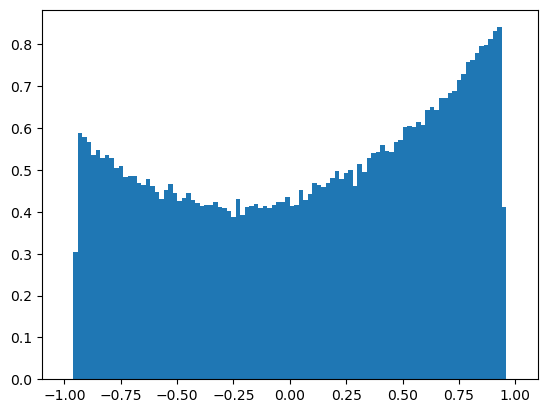

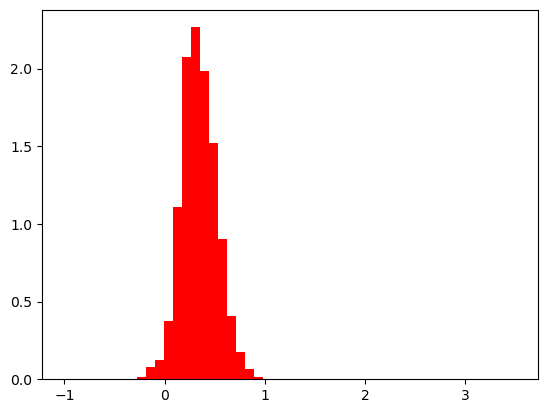

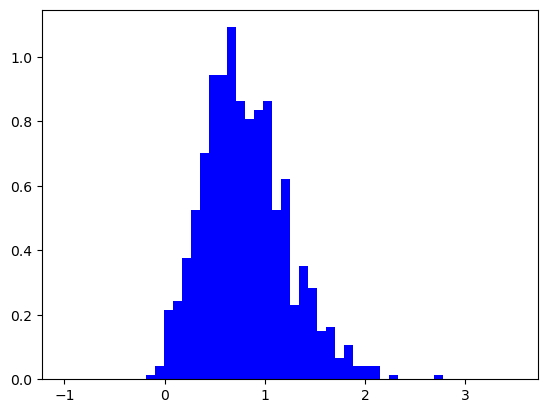

In [110]:
# ML + MC

# Ora che abbiamo la stima di alpha e beta calcoliamo la varianza con Montecarlo

# Per farlo ci generiamo N prove con nOss osservazioni
# Per ogni blocco di osservazioni ci stimiamo di nuovo alpha e beta, 
# come risultato avremo due array di stime di alpha e beta, 
# da questi due array ci calcoliamo la varianza, per farlo usiamo la formula della sample variance


# Numero di prove e osservazioni
N = 300000
nOss = 200

rand_x = np.random.uniform(xmin,xmax,N)

# mi calcolo la y dalla formula della funzione
y = f(rand_x,estimated_alpha,estimated_beta)
# Trovo la fmax guardando semplicemente i dati generati poi 
# ci aggiungo 0.1 per essere più sicuro di coprire tutto 
# lo spazio possibile della funzione e mi calcolo la y random
fmax = max(y)
rand_y = np.random.uniform(0,fmax+0.1,N)


accepted_x = []
count = 0

# hit or miss
for i in range(N):
  if(rand_y[i] < y[i]):
    accepted_x.append(rand_x[i])
    count = count + 1


estimated_alpha_array_from_MC = []
estimated_beta_array_from_MC = []
# Suddivido le x accettate in varie osservazioni
# per ogni sample di osservazioni mi ricalcolo alpha e beta
for j in range(int(count/nOss)):
    # Eseguo l'ottimizzazione
    result = minimize(NegativeLogLikelihood, [0.0, 0.0],np.array((accepted_x[nOss*j:nOss*(j+1)])), method='Nelder-Mead')
    # Estraggo le stime di alpha e beta dal risultato
    estimated_alpha_MC, estimated_beta_MC = result.x
    # Aggiungo le stime all'array di stime
    estimated_alpha_array_from_MC.append(estimated_alpha_MC)
    estimated_beta_array_from_MC.append(estimated_beta_MC)


# Qui vado a fare la media di tutti i valori dell'array. 
# Quindi ricavo la media della stima delle alpha e delle beta.
mean_estimated_alpha_MC = np.mean(estimated_alpha_array_from_MC)
mean_estimated_beta_MC = np.mean(estimated_beta_array_from_MC)

# Qui ci calcoliamo la varianza con la formula della sample variance
# in questo pezzo facciamo la sommatoria delle xi con i che va da 1 a n, di (xi-x)^2
# dove la x è il parametro che abbiamo stimato inizialmente con ML
var_alpha = 0
var_beta = 0
for j in range(int(count/nOss)):
    var_alpha = var_alpha + (estimated_alpha_array_from_MC[j]-estimated_alpha)**2
    var_beta = var_beta + (estimated_beta_array_from_MC[j]-estimated_beta)**2
# qui facciamo il pezzo della formula 1/(n-1)
var_alpha = var_alpha/(int(count/nOss)-1)
var_beta = var_beta/(int(count/nOss)-1)

# Qui ci calcoliamo la varianza con la formula della sample variance
# in questo pezzo facciamo la sommatoria delle xi con i che va da 1 a n, di (xi-x)^2
# dove la x è la media dei parametri stimati con montecarlo
var_alpha_MC = 0
var_beta_MC = 0
for j in range(int(count/nOss)):
    var_alpha_MC = var_alpha_MC + (estimated_alpha_array_from_MC[j]-mean_estimated_alpha_MC)**2
    var_beta_MC = var_beta_MC + (estimated_beta_array_from_MC[j]-mean_estimated_beta_MC)**2
# qui facciamo il pezzo della formula 1/(n-1)
var_alpha_MC = var_alpha_MC/(int(count/nOss)-1)
var_beta_MC = var_beta_MC/(int(count/nOss)-1)



print(f"Media delle alpha stimate da MC = {mean_estimated_alpha_MC:.3f}")
print(f"Media delle beta stimate da MC = {mean_estimated_beta_MC:.3f}")
print(f"Deviazione standard di alpha rispetto alle medie ricavate da MC = {np.sqrt(var_alpha_MC):.3f}")
print(f"Deviazione standard di beta rispetto alle medie ricavate da MC = {np.sqrt(var_beta_MC):.3f}")
print(f"Deviazione standard di alpha rispetto al parametro iniziale = {np.sqrt(var_alpha):.3f}")
print(f"Deviazione standard di beta rispetto al parametro iniziale = {np.sqrt(var_beta):.3f}")
print(f"Alpha = {estimated_alpha:.2f} ± {np.sqrt(var_alpha):.2f}")
print(f"Beta = {estimated_beta:.2f} ± {np.sqrt(var_beta):.2f}")


# Grafico della pdf della formula
plt.hist(accepted_x,100,(-1,1), density=True)
plt.show()
# Grafico della distribuzione dei parametri
plt.hist(estimated_alpha_array_from_MC,50,(-1,3.5), color = "red", density = True)
plt.show()
plt.hist(estimated_beta_array_from_MC,50,(-1,3.5), color = "blue", density = True)
plt.show()

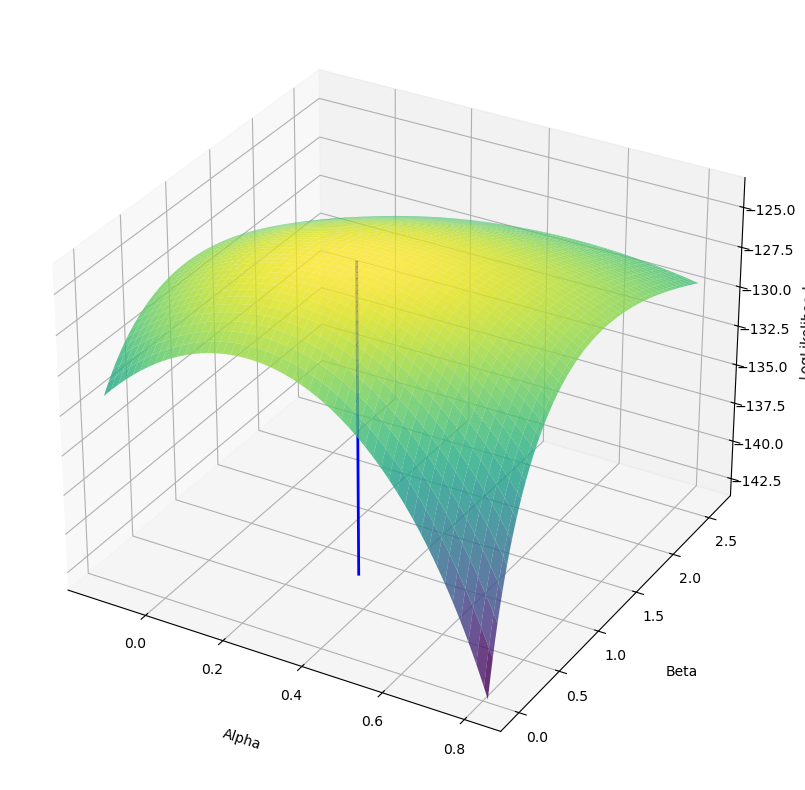

In [111]:

# Grafico della ML

# Funzione LogL per il grafico
def LogLikelihoodForGrid(params,x):
  alpha, beta = params
  result = 0
  for i in range(len(x)):
      result += (np.log(f(x[i],alpha,beta)))
  return result


#prendo il massimo e il minimo dei parametri alpha e beta dalle simulazioni MC
alpha_min = np.nanmin(estimated_alpha_array_from_MC)
alpha_max = np.nanmax(estimated_alpha_array_from_MC)
beta_min = np.nanmin(estimated_beta_array_from_MC)
beta_max = np.nanmax(estimated_beta_array_from_MC)
# rimpicciolisco di poco il range per evitare valore <= 0 per il log
alpha = np.linspace(alpha_min+0.1,alpha_max-0.1,100)
beta = np.linspace(beta_min+0.1,beta_max-0.1,100)

Alpha,Beta = np.meshgrid(alpha,beta)
params = Alpha,Beta
Result = LogLikelihoodForGrid(params,x_from_data)

# Trova i valori più alto e più basso dell'asse z
z_min = np.nanmin(Result.flatten())
z_max = np.nanmax(Result.flatten())

# Calcolo i parametri di una linea che parte dal punto in cui la funzione si massimizza e arriva fino in fondo lungo l'asse z
z_line = np.linspace(z_min, z_min + (z_max-z_min), 100)
x_line = estimated_alpha * np.ones(100)
y_line = estimated_beta * np.ones(100)

# Crea il grafico 3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Alpha, Beta, Result, cmap='viridis', alpha=0.8)
#aggiungo la linea del punto massimo
ax.plot(x_line, y_line, z_line, color='b', linewidth=2)

ax.set_xlabel('Alpha', labelpad=20)
ax.set_ylabel('Beta', labelpad=20)
ax.set_zlabel('LogLikelihood', labelpad= 10)
plt.show()

In [112]:
# ML + RFC BOUND

# Qui faccio il calcolo analitico sfruttando l'RFC Bound facendo la derivata 
# seconda su alpha e beta, in questo modo trovo la varianza di ogni parametro

import sympy as sp


alpha,beta = sp.symbols('alpha beta')
# formula loglikelihood per sympy
def LogLikelihood_symbol(x,alpha,beta):
  result = 0
  for i in range(len(x)):
    result += (sp.log(f(x[i],alpha,beta)))
  return result


log_likelihood = LogLikelihood_symbol(x_from_data,alpha,beta)

# Qui faccio la derivata della LogLikelihood rispetto ad alpha e beta
d_log_likelihood_alpha = sp.diff(log_likelihood, alpha)
d_log_likelihood_beta = sp.diff(log_likelihood,beta)

# Qui rifaccio la derivata della derivata precedente rispetto ad alpha e beta (quindi ora ho il calcolo delle derivate seconde)
d2_log_likelihood_alpha = sp.diff(d_log_likelihood_alpha, alpha)
d2_log_likelihood_beta = sp.diff(d_log_likelihood_beta,beta)

# Faccio la conversione in funzioni lambda per sympy
d2_log_likelihood_alpha_func = sp.lambdify((alpha,beta), d2_log_likelihood_alpha, 'numpy')
d2_log_likelihood_beta_func = sp.lambdify((alpha,beta), d2_log_likelihood_beta, 'numpy')

var_alpha_rcf = 1/-(d2_log_likelihood_alpha_func(estimated_alpha,estimated_beta))
var_beta_rcf = 1/-(d2_log_likelihood_beta_func(estimated_alpha,estimated_beta))

# Qui stampiamo le deviazioni standard calcolandole dalla stima di alpha e beta fatta inizialmente con metodo ML
print(f"Deviazione standard di alpha = {np.sqrt(var_alpha_rcf):.3f}")
print(f"Deviazione standard di beta = {np.sqrt(var_beta_rcf):.3f}")
print(f"Alpha = {estimated_alpha:.2f} ± {np.sqrt(var_alpha_rcf):.2f}")
print(f"Beta = {estimated_beta:.2f} ± {np.sqrt(var_beta_rcf):.2f}")

Deviazione standard di alpha = 0.167
Deviazione standard di beta = 0.389
Alpha = 0.33 ± 0.17
Beta = 0.76 ± 0.39
